# MVBS from 1 raw data file, compare `coarsen` and brute force

Compare using `coarsen` (based on index) and brute force MVBS calculation --> verified that the results are the same up to 1e-14.

Also tested MVBS calculation using `resample` (based on time) + `groupby_bins`, with 1-hour intervel.

In [1]:
import os
import glob
import xarray as xr

In [2]:
import time

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from dask.distributed import Client
client = Client()

In [5]:
from dask.distributed import performance_report

In [6]:
nc_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_raw/'
nc_files = sorted(glob.glob(nc_path+'*.nc'))   # sort to order by date in filename

## Load multiple data files

In [7]:
nc_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_Sv/'
nc_Sv_files = sorted(glob.glob(nc_path+'*_Sv.nc'))   # sort to order by date in filename

Let's first try this with 1 file.

In [12]:
ds_mf = xr.open_mfdataset(nc_Sv_files[0], combine='by_coords')
ds_mf

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 28718, range_bin: 1046)
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * ping_time  (ping_time) datetime64[ns] 2015-08-17T00:00:00.088000 ... 2015-08-17T23:19:59.703000
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045
Data variables:
    Sv         (frequency, ping_time, range_bin) float64 dask.array<chunksize=(3, 28718, 1046), meta=np.ndarray>
    range      (frequency, range_bin) float64 dask.array<chunksize=(3, 1046), meta=np.ndarray>

In [13]:
ds_mf_chunk = xr.open_mfdataset(nc_Sv_files[0], combine='by_coords').chunk({'ping_time': 4000})
ds_mf_chunk

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 28718, range_bin: 1046)
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * ping_time  (ping_time) datetime64[ns] 2015-08-17T00:00:00.088000 ... 2015-08-17T23:19:59.703000
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045
Data variables:
    Sv         (frequency, ping_time, range_bin) float64 dask.array<chunksize=(3, 4000, 1046), meta=np.ndarray>
    range      (frequency, range_bin) float64 dask.array<chunksize=(3, 1046), meta=np.ndarray>

In [14]:
ds_mf_chunk.chunks

Frozen(SortedKeysDict({'frequency': (3,), 'ping_time': (4000, 4000, 4000, 4000, 4000, 4000, 4000, 718), 'range_bin': (1046,)}))

In [15]:
ds_mf_chunk.Sv.data

dask.array<rechunk-merge, shape=(3, 28718, 1046), dtype=float64, chunksize=(3, 4000, 1046), chunktype=numpy.ndarray>

In [16]:
ds_mf.Sv.data

dask.array<open_dataset-492e4ddb3f794769b9513d2936132204Sv, shape=(3, 28718, 1046), dtype=float64, chunksize=(3, 28718, 1046), chunktype=numpy.ndarray>

## Get various variables for MVBS calculation

Calculating sample thickness, which will be used to determine the number of range bins used for each MVBS tile.

In [17]:
with xr.open_dataset(nc_files[0], group="Beam") as ds_beam:
    with xr.open_dataset(nc_files[0], group="Environment") as ds_env:
        sample_thickness = ds_env.sound_speed_indicative * ds_beam.sample_interval / 2  # sample thickness
sample_thickness

<xarray.DataArray (frequency: 3)>
array([0.19121777, 0.19121777, 0.19121777], dtype=float32)
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0

Set range bin (depth) and ping number sizes for each MVBS tile.

In [18]:
MVBS_range_bin_size = 5  # [m]
MVBS_ping_size = 40      # ping number

Adjust tile range bin size so that it is an integer multiple of the sample thickness.

In [19]:
# Adjust noise_est_range_bin_size because range_bin_size may be an inconvenient value
r_data_sz = ds_mf_chunk['range_bin'].size   # dimension of range_bin in data file
num_r_per_tile = (np.round(MVBS_range_bin_size / sample_thickness).
                  astype(int)).values.max()  # num of range_bin per tile
MVBS_range_bin_size = (num_r_per_tile * sample_thickness).values

num_tile_range_bin = np.ceil(r_data_sz / num_r_per_tile).astype(int)

print(f'There are {num_r_per_tile} range bins in each MVBS tile.')
print(f'There are a total of {num_tile_range_bin} range_bin bins for each Sv tile.')

There are 26 range bins in each MVBS tile.
There are a total of 41 range_bin bins for each Sv tile.


Below are the bin edges we will use to group values along the `range_bin` dimension:

In [20]:
r_tile_bin_edge = np.arange(num_tile_range_bin+1) * num_r_per_tile - 1
r_tile_bin_edge

array([  -1,   25,   51,   77,  103,  129,  155,  181,  207,  233,  259,
        285,  311,  337,  363,  389,  415,  441,  467,  493,  519,  545,
        571,  597,  623,  649,  675,  701,  727,  753,  779,  805,  831,
        857,  883,  909,  935,  961,  987, 1013, 1039, 1065])

In [39]:
p_data_sz = ds_mf_chunk['ping_time'].size   # dimension of ping_time in data file
p_data_sz

28718

In [43]:
p_tile_bin_edge = np.arange(num_tile_ping) * MVBS_ping_size - 1
p_tile_bin_edge

array([   -1,    39,    79,   119,   159,   199,   239,   279,   319,
         359,   399,   439,   479,   519,   559,   599,   639,   679,
         719,   759,   799,   839,   879,   919,   959,   999,  1039,
        1079,  1119,  1159,  1199,  1239,  1279,  1319,  1359,  1399,
        1439,  1479,  1519,  1559,  1599,  1639,  1679,  1719,  1759,
        1799,  1839,  1879,  1919,  1959,  1999,  2039,  2079,  2119,
        2159,  2199,  2239,  2279,  2319,  2359,  2399,  2439,  2479,
        2519,  2559,  2599,  2639,  2679,  2719,  2759,  2799,  2839,
        2879,  2919,  2959,  2999,  3039,  3079,  3119,  3159,  3199,
        3239,  3279,  3319,  3359,  3399,  3439,  3479,  3519,  3559,
        3599,  3639,  3679,  3719,  3759,  3799,  3839,  3879,  3919,
        3959,  3999,  4039,  4079,  4119,  4159,  4199,  4239,  4279,
        4319,  4359,  4399,  4439,  4479,  4519,  4559,  4599,  4639,
        4679,  4719,  4759,  4799,  4839,  4879,  4919,  4959,  4999,
        5039,  5079,

In [42]:
p_tile_bin_edge.size

719

In [37]:
num_tile_ping = np.ceil(p_data_sz / MVBS_ping_size).astype(int) + 1
num_tile_ping

719

In [21]:
# Produce a new coordinate for groupby operation
p_data_sz = ds_mf_chunk['ping_time'].size   # dimension of ping_time in data file
if np.mod(p_data_sz, MVBS_ping_size) == 0:
    num_tile_ping = np.ceil(p_data_sz / MVBS_ping_size).astype(int) + 1
    p_idx = np.array([np.arange(num_tile_ping - 1)] * MVBS_ping_size).squeeze().T.ravel()
else:
    num_tile_ping = np.ceil(p_data_sz / MVBS_ping_size).astype(int)
    pad = np.ones(p_data_sz - (num_tile_ping - 1) * MVBS_ping_size, dtype=int) \
          * (num_tile_ping - 1)
    p_idx = np.hstack(
        (np.array([np.arange(num_tile_ping - 1)] * MVBS_ping_size).squeeze().T.ravel(), pad))

In [22]:
p_idx

array([  0,   0,   0, ..., 717, 717, 717])

In [23]:
p_data_sz/MVBS_ping_size

717.95

Let's now calculate the actual range (in meters) for the data set.

In [24]:
tvg_correction_factor = 2
with xr.open_dataset(nc_files[0], group="Beam") as ds_beam:
    range_meter = ds_beam.range_bin * sample_thickness - \
                  tvg_correction_factor * sample_thickness  # DataArray [frequency x range_bin]
    range_meter = range_meter.where(range_meter > 0, other=0)

In [25]:
range_meter.T

<xarray.DataArray (frequency: 3, range_bin: 1046)>
array([[  0.        ,   0.        ,   0.        , ..., 199.05769359,
        199.24891135, 199.44012912],
       [  0.        ,   0.        ,   0.        , ..., 199.05769359,
        199.24891135, 199.44012912],
       [  0.        ,   0.        ,   0.        , ..., 199.05769359,
        199.24891135, 199.44012912]])
Coordinates:
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045
  * frequency  (frequency) float32 120000.0 38000.0 200000.0

## MVBS computation

In the original code we needed to add one more coordinate variable `add_idx` in order to use `groupby` to calculate averages along the `ping_time` dimension. We also needed to do explicit `groupby_bins` operation to calculate averages along the `range_bin` dimension. 

Now with the `coarsen` function -- which was designed to perform multi-dimensional block-wise computations -- we don't need to do these explicitly, IF the average along `ping_time` is based on index. If the average along `ping_time` is based on the time itself, we can then use `resample` to perform the average first along `ping_time` and then use `groupby_bins` along `range_bin`.

### Based on index along `ping_time`

In the above we also chunked the loaded Sv data into blocks of 4000, which would work well if the MVBS cell size along `ping_time` is 40. 

One thing we should try in echopype is to change the chunk size according to the specified desired MVBS cell size right before computing MVBS to see if it makes the computation more efficient.

In [91]:
# We can simply use coarsen for this operation
MVBS_coarsen_chunk = ds_mf_chunk.coarsen(ping_time=1200, 
                                         range_bin=num_r_per_tile, 
                                         boundary='pad').mean()
MVBS_coarsen_chunk.compute()

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 24, range_bin: 41)
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * ping_time  (ping_time) datetime64[ns] 2015-08-17T00:10:10.478174166 ... 2015-08-17T23:10:39.497937388
  * range_bin  (range_bin) float64 12.5 38.5 64.5 ... 1e+03 1.026e+03 1.042e+03
    ping_idx   (ping_time) float64 599.5 1.8e+03 3e+03 ... 2.7e+04 2.816e+04
Data variables:
    Sv         (frequency, ping_time, range_bin) float64 -62.33 ... -38.96
    range      (frequency, range_bin) float64 2.03 6.979 11.95 ... 195.9 199.0

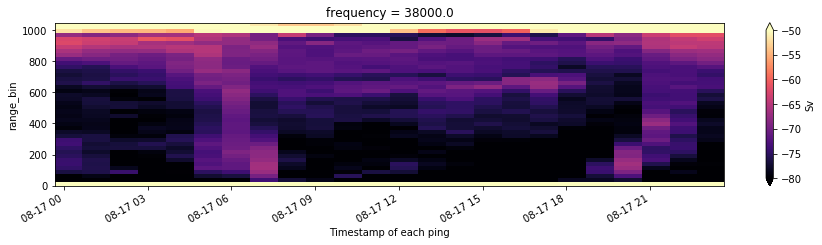

In [92]:
fig, ax = plt.subplots(figsize=(15,3))
MVBS_coarsen_chunk['Sv'].sel(frequency=38000).\
    plot(ax=ax, x='ping_time',cmap='magma',vmin=-50,vmax=-80)
plt.show()

In [36]:
MVBS_from_coarsen_values = MVBS_coarsen_chunk['Sv'].sel(frequency=38000).values

One thing we should test is if the coarsen operation really produce the same results as the brute force `groupby` and `groupby_bins` operations used in the original code.

Let's try to calculate MVBS using the original operation.

In [54]:
ds_mf_chunk.coords['ping_idx'] = ('ping_time', np.arange(ds_mf_chunk['ping_time'].size))
ds_mf_chunk.swap_dims({'ping_time': 'ping_idx'})

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_idx: 28718, range_bin: 1046)
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
    ping_time  (ping_idx) datetime64[ns] 2015-08-17T00:00:00.088000 ... 2015-08-17T23:19:59.703000
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045
  * ping_idx   (ping_idx) int64 0 1 2 3 4 5 ... 28713 28714 28715 28716 28717
Data variables:
    Sv         (frequency, ping_idx, range_bin) float64 dask.array<chunksize=(3, 4000, 1046), meta=np.ndarray>
    range      (frequency, range_bin) float64 dask.array<chunksize=(3, 1046), meta=np.ndarray>

In [58]:
MVBS_chunk = ds_mf_chunk['Sv'].sel(frequency=38000).\
                groupby_bins('ping_idx',p_tile_bin_edge).mean('ping_time').\
                groupby_bins('range_bin', r_tile_bin_edge).mean('range_bin')
MVBS_from_groupby_values = MVBS_chunk.values

distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [224]:
%time
MVBS_chunk = ds_mf_chunk.Sv.sel(frequency=38000).groupby('add_idx').mean('ping_time').\
                groupby_bins('range_bin', r_tile_bin_edge).mean('range_bin')
MVBS_chunk.compute()
MVBS_from_groupby_values = MVBS_chunk.values

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [59]:
MVBS_from_coarsen_values[:10,0]

array([-46.15908517, -46.80226769, -46.79573241, -46.78587295,
       -46.78649482, -46.65451153, -46.55760167, -45.81349541,
       -45.58275927, -46.58851423])

In [60]:
MVBS_from_groupby_values[:10,0]

array([-46.15908517, -46.80226769, -46.79573241, -46.78587295,
       -46.78649482, -46.65451153, -46.55760167, -45.81349541,
       -45.58275927, -46.58851423])

In [64]:
np.isclose(MVBS_from_coarsen_values[:10,0], MVBS_from_groupby_values[:10,0], atol=1e-13, rtol=0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [65]:
np.isclose(MVBS_from_coarsen_values[:10,0], MVBS_from_groupby_values[:10,0], atol=1e-14, rtol=0)

array([ True,  True, False,  True,  True, False,  True,  True,  True,
        True])

In [66]:
MVBS_from_coarsen_values[2,0]

-46.79573240806343

In [67]:
MVBS_from_groupby_values[2,0]

-46.79573240806341

The computations are pretty much equivalent with difference on the order of 1e-13.

### Based on time along ping_time

The coarsen operation can only be based on index, so to compute MVBS based on the actual timestamp, we will need to combined `resample` and `groupby_bins` along the `ping_time` and `range_bin` dimensions, respectively.

Let's do this by trying to produce MVBS with a cell size of 20 min x ~5 m.

In [84]:
MVBS_time_chunk = ds_mf_chunk['Sv'].resample(ping_time='1H').mean()
MVBS_time_chunk

<xarray.DataArray 'Sv' (frequency: 3, ping_time: 24, range_bin: 1046)>
dask.array<transpose, shape=(3, 24, 1046), dtype=float64, chunksize=(3, 1, 1046), chunktype=numpy.ndarray>
Coordinates:
  * ping_time  (ping_time) datetime64[ns] 2015-08-17 ... 2015-08-17T23:00:00
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 ... 1040 1041 1042 1043 1044 1045

Let's check the ping time to make sure results of the resampling operation makes sens:

In [85]:
MVBS_time_chunk['ping_time']

<xarray.DataArray 'ping_time' (ping_time: 24)>
array(['2015-08-17T00:00:00.000000000', '2015-08-17T01:00:00.000000000',
       '2015-08-17T02:00:00.000000000', '2015-08-17T03:00:00.000000000',
       '2015-08-17T04:00:00.000000000', '2015-08-17T05:00:00.000000000',
       '2015-08-17T06:00:00.000000000', '2015-08-17T07:00:00.000000000',
       '2015-08-17T08:00:00.000000000', '2015-08-17T09:00:00.000000000',
       '2015-08-17T10:00:00.000000000', '2015-08-17T11:00:00.000000000',
       '2015-08-17T12:00:00.000000000', '2015-08-17T13:00:00.000000000',
       '2015-08-17T14:00:00.000000000', '2015-08-17T15:00:00.000000000',
       '2015-08-17T16:00:00.000000000', '2015-08-17T17:00:00.000000000',
       '2015-08-17T18:00:00.000000000', '2015-08-17T19:00:00.000000000',
       '2015-08-17T20:00:00.000000000', '2015-08-17T21:00:00.000000000',
       '2015-08-17T22:00:00.000000000', '2015-08-17T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * ping_time  (ping_time) dateti

In [86]:
MVBS_time_range_chunk = MVBS_time_chunk.groupby_bins('range_bin',r_tile_bin_edge).mean()
MVBS_time_range_chunk

<xarray.DataArray 'Sv' (frequency: 3, ping_time: 24, range_bin_bins: 41)>
dask.array<transpose, shape=(3, 24, 41), dtype=float64, chunksize=(3, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * range_bin_bins  (range_bin_bins) object (-1, 25] (25, 51] ... (1039, 1065]
  * ping_time       (ping_time) datetime64[ns] 2015-08-17 ... 2015-08-17T23:00:00
  * frequency       (frequency) float32 120000.0 38000.0 200000.0

In [87]:
MVBS_time_range_chunk_values = MVBS_time_range_chunk.sel(frequency=38000).compute().values

distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


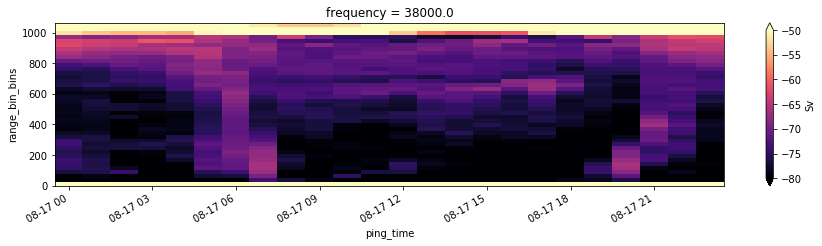

In [88]:
fig, ax = plt.subplots(figsize=(15,3))
MVBS_time_range_chunk.sel(frequency=38000).\
    plot(ax=ax, x='ping_time',cmap='magma',vmin=-50,vmax=-80)